In [2]:
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import os

In [5]:
PATH_TO_DATA = "/kaggle/input/facades-dataset"

# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3

NUM_OF_DATA = len(glob.glob(os.path.join(PATH_TO_DATA, "trainA/*")))
NUM_OF_DATA_TEST = len(glob.glob(os.path.join(PATH_TO_DATA, "testA/*")))
NUM_OF_DATA, NUM_OF_DATA_TEST

(400, 106)

In [6]:
def read_input_and_real_image(index: int, is_test=False):
    if is_test:
        path_real = f"testA/{index}.jpg"
        path_input = f"testB/{index}.jpg"
    else:
        path_real = f"trainA/{index}_A.jpg"
        path_input = f"trainB/{index}_B.jpg"
    train_real_path = os.path.join(PATH_TO_DATA, path_real)
    train_input_path = os.path.join(PATH_TO_DATA, path_input)
    
    train_real = tf.io.read_file(train_real_path)
    train_real = tf.io.decode_jpeg(train_real)
    
    train_input = tf.io.read_file(train_input_path)
    train_input = tf.io.decode_jpeg(train_input)
    return train_input, train_real

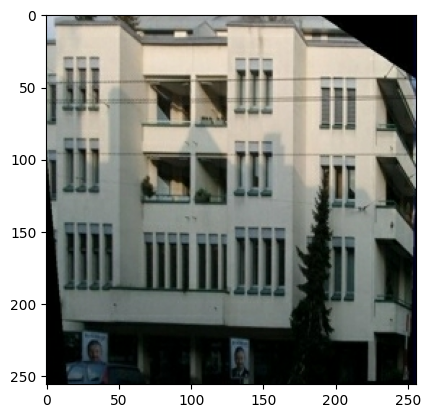

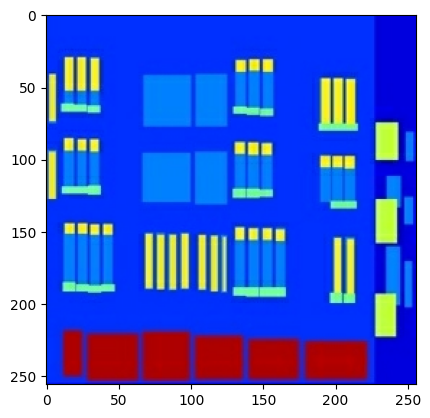

In [7]:
single_input, single_real = read_input_and_real_image(1)
plt.figure()
plt.imshow(single_real)
plt.figure()
plt.imshow(single_input)

In [8]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
          stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]
    )

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (tf.cast(input_image, dtype=tf.float32) / 127.5) - 1
    real_image = (tf.cast(real_image, dtype=tf.float32) / 127.5) - 1

    return input_image, real_image


@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

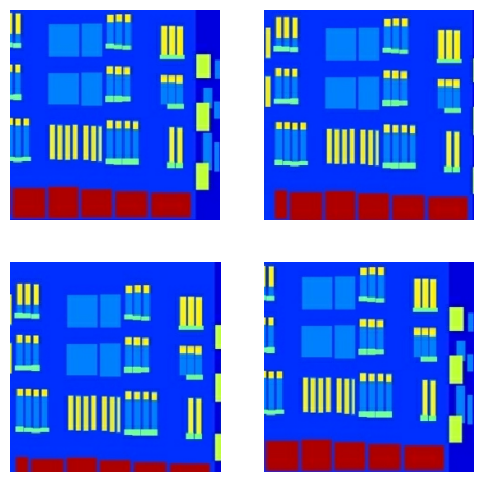

In [9]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_input, rj_real = random_jitter(single_input, single_real)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_input)
    plt.axis('off')
plt.show()

In [10]:
def data_generator(is_test=False):
    if is_test:
        max_number = NUM_OF_DATA_TEST
    else:
        max_number = NUM_OF_DATA
    
    counter = 1
    while True:
        input_image, real_image = read_input_and_real_image(counter, is_test=is_test)
        yield input_image, real_image
        
        counter += 1
        if counter > max_number:
            counter = 1
        

def load_image_train(input_image, real_image):
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


def load_image_test(input_image, real_image):
    input_image, real_image = resize(
        input_image, real_image,
        IMG_HEIGHT, IMG_WIDTH
    )
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [11]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(is_test=False),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8),
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8))
)
train_dataset = train_dataset.map(
    load_image_train, num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(NUM_OF_DATA)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [12]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(is_test=True),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8),
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8))
)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

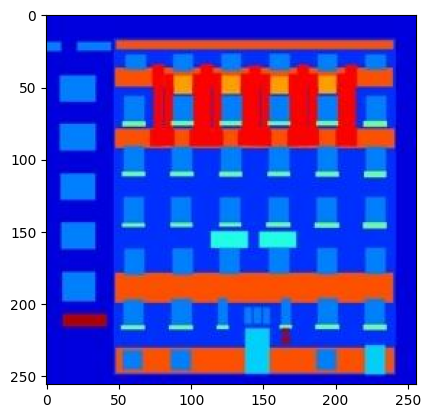

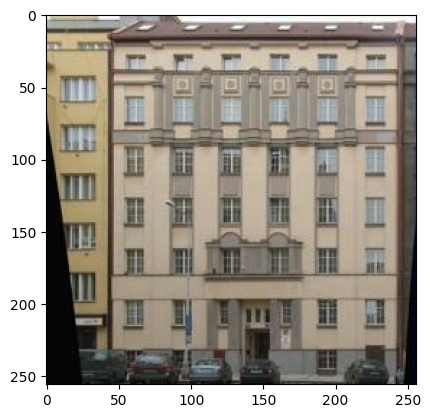

In [13]:
input_image, real_image = next(iter(test_dataset))
plt.figure()
plt.imshow((input_image[0]+1)/2)
plt.figure()
plt.imshow((real_image[0]+1)/2)

In [14]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False)
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [15]:
down_model = downsample(3, 4)
down_result = down_model(input_image)
print (down_result.shape)

(1, 128, 128, 3)


In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,padding='same',
            kernel_initializer=initializer,use_bias=False)
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
          result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [18]:
class Generator(tf.Module):
    
    def __init__(self):
        self.down_stack = [
            downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            downsample(128, 4),  # (batch_size, 64, 64, 128)
            downsample(256, 4),  # (batch_size, 32, 32, 256)
            downsample(512, 4),  # (batch_size, 16, 16, 512)
            downsample(512, 4),  # (batch_size, 8, 8, 512)
            downsample(512, 4),  # (batch_size, 4, 4, 512)
            downsample(512, 4),  # (batch_size, 2, 2, 512)
            downsample(512, 4),  # (batch_size, 1, 1, 512)
        ]

        self.up_stack = [
            upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            upsample(512, 4),  # (batch_size, 16, 16, 1024)
            upsample(256, 4),  # (batch_size, 32, 32, 512)
            upsample(128, 4),  # (batch_size, 64, 64, 256)
            upsample(64, 4),  # (batch_size, 128, 128, 128)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        self.last = tf.keras.layers.Conv2DTranspose(
            OUTPUT_CHANNELS, 4, strides=2,
            padding='same',kernel_initializer=initializer,
            activation='tanh'
        )  # (batch_size, 256, 256, 3)

    def __call__(self, x, training=False):
        skips = []
        for down in self.down_stack:
            x = down(x, training=training)
            skips.append(x)
        skips = reversed(skips[:-1])
        for up, skip in zip(self.up_stack, skips):
            x = up(x, training=training)
            x = tf.concat([x, skip], axis=-1)
        x = self.last(x, training=training)
        return x

In [19]:
generator = Generator()

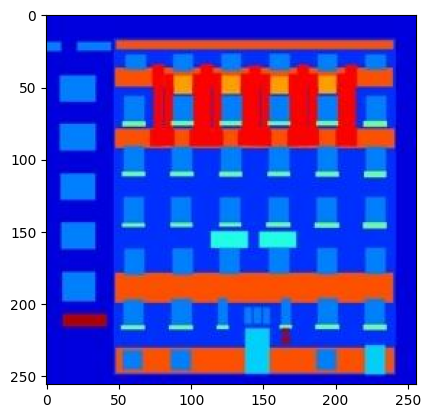

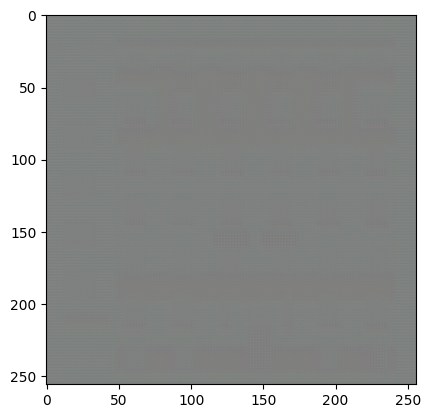

In [20]:
gen_output = generator(input_image)
plt.figure()
plt.imshow((input_image[0]+1)/2)
plt.figure()
plt.imshow((gen_output[0]+1)/2)

In [21]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [22]:
class Discriminator(tf.Module):
    
    def __init__(self):
        initializer = tf.random_normal_initializer(0., 0.02)

        self.down1 = downsample(64, 4, False)  # (batch_size, 128, 128, 64)
        self.down2 = downsample(128, 4)  # (batch_size, 64, 64, 128)
        self.down3 = downsample(256, 4)  # (batch_size, 32, 32, 256)

        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()  # (batch_size, 34, 34, 256)
        self.conv = tf.keras.layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer,
            use_bias=False
        )  # (batch_size, 31, 31, 512)

        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        self.leaky_relu = tf.keras.layers.LeakyReLU()

        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()  # (batch_size, 33, 33, 512)

        self.last = tf.keras.layers.Conv2D(
            1, 4, strides=1,kernel_initializer=initializer
        )  # (batch_size, 30, 30, 1)
    
    def __call__(self, input_x, target_x, training=False):
        x = tf.concat([input_x, target_x], axis=-1)
        x = self.down1(x, training=training)
        x = self.down2(x, training=training)
        x = self.down3(x, training=training)
        x = self.zero_pad1(x, training=training)
        x = self.conv(x, training=training)
        x = self.batchnorm1(x, training=training)
        x = self.leaky_relu(x, training=training)
        x = self.zero_pad2(x, training=training)
        x = self.last(x, training=training)
        return x

In [23]:
discriminator = Discriminator()

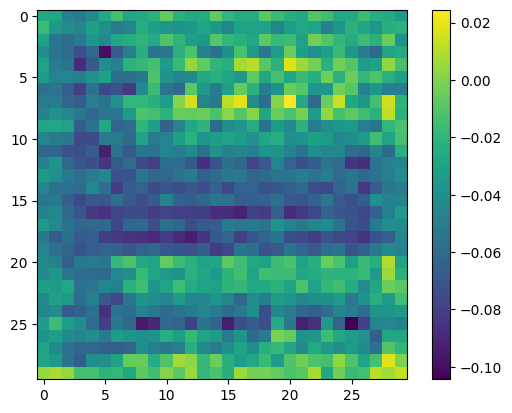

In [24]:
disc_out = discriminator(gen_output, input_image)
plt.figure()
plt.imshow(disc_out[0])
plt.colorbar()

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

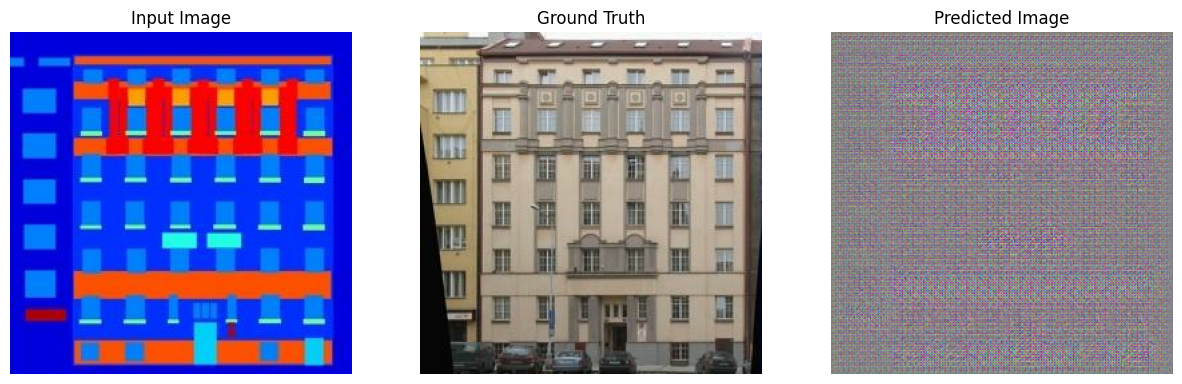

In [29]:
for example_input, example_target in test_dataset.take(1):
      generate_images(generator, example_input, example_target)